In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.sparse.csgraph import connected_components, shortest_path
from pprint import pprint

# I know both of the below won't work haha
# TODO: test non square dungeons
# TODO: test square densities other than 3

In [48]:
class Dungeon:
    def __init__(self, party, m=10, n=10, p_wall=0.3, square_density=3, plot_size=20):
        self.party = party
        self.m = m
        self.n = n
        self.square_density = square_density
        self.p_wall = p_wall
        self.plot_size = plot_size
        self.difficulty_dict = {
            'Trivial': 0,
            'Easy': 1,
            'Medium': 2,
            'Hard': 3,
            'Deadly': 4,
            0: 'Trivial',
            1: 'Easy',
            2: 'Medium',
            3: 'Hard',
            4: 'Deadly'
        }
        
        self.generate_map()
        self.place_encounters()
        self.plot_dungeon()
        
        self.monster_df = pd.read_csv('dnd_monsters.csv', index_col=0)
        self.player_df = pd.read_csv('dnd_player_exp', index_col=0)
        
        self.generate_encounters()
           
    def generate_map(self):
        """
        Given dimensions m and n, generate a dungeon map.

        Parameters
        ----------
        m, n:  int
            Integers representing the dimensions of the dungeon.

        p_wall:  float, optional
            Float between 0 and 1, specifies the density of
            walls within the dungeon.
        

        Returns
        -------
        A:  numpy array
            Array representing the vertical walls within the 
            dungeon. If A[i, j] is 1, there is a wall at i, j.
            A is m x n-1.

        B:  numpy array
            Array representing the horizontal walls within the 
            dungeon. If B[i, j] is 1, there is a wall at i, j.
            B is m-1 x n.

        C:  numpy array
            Undirected adjacency matrix for the dungeon. C[i, j]
            is 1 if the jth square is adjacent to the ith square.
            Used to determine connected components.
            C is m*n x m*n.

        """
        m = self.m
        n = self.n
        p_wall = self.p_wall
        
        def _adjacency(A, B):
            """
            Helper function to determine the adjacency matrix
            C from wall matrices A and B.
            """
            m, n = A.shape[0], B.shape[1]
            C = np.zeros((m*n, m*n))  # C is m*n x m*n

            def _get_i_j(ind):
                """
                Helper function to get the i, j index of a 
                square within the grid given its index in C.
                """
                i = ind // n
                j = ind % n
                return i, j

            def _get_ind(i, j):
                """
                Helper function to get the index in C given
                a square's i, j index within the grid.
                """
                return i*n + j

            # loop over all squares in the grid
            for ind in range(m*n):
                i, j = _get_i_j(ind)

                if i != 0:  # look up
                    if B[i-1, j] == 0:  # check for walls
                        C[ind, _get_ind(i-1, j)] = 1

                if i != m-1:  # look down
                    if B[i, j] == 0:  # check for walls
                        C[ind, _get_ind(i+1, j)] = 1

                if j != 0:  # look left
                    if A[i, j-1] == 0:  # check for walls
                        C[ind, _get_ind(i, j-1)] = 1

                if j != n-1:  # look right
                    if A[i, j] == 0:  # check for walls
                        C[ind, _get_ind(i, j+1)] = 1

            return C + np.eye(m*n)

        # get random wall matrices using p_wall
        A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
        B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
        C = _adjacency(A, B)

        # loop until connected components condition is satisfied
        # TODO: add either a maxiter or a timeout
        while connected_components(C)[0] > 1:
            A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
            B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
            C = _adjacency(A, B)
        
        self.A = A  # vertical walls
        self.B = B  # horizontal walls
        self.C = C  # adjacency matrix
        
    def place_encounters(self):
        m = self.m
        n = self.n
        square_density = self.square_density
        
        D = np.zeros((square_density*m, square_density*n))

        short_paths = shortest_path(self.C)
        longest_path = np.unravel_index(short_paths.argmax(), self.C.shape)
        party_location_granular = self._get_i_j(longest_path[0], n)
        treasure_location_granular = self._get_i_j(longest_path[1], n)
        
        party_location = self._granular_to_dense(*party_location_granular)
        treasure_location = self._granular_to_dense(*treasure_location_granular)
        self.party_location = party_location
        self.treasure_location = treasure_location
        
        D[treasure_location[0], treasure_location[1]] = 4
        D[party_location[0], party_location[1]] = -1

        locations = [treasure_location, party_location]
        self.encounter_locs = {'Deadly': treasure_location}
        
        for i in [1, 2, 3]:
            valid_location = False
            while not valid_location:
                new_location_granular = self._get_i_j(np.random.choice(m*n))
                new_location = self._granular_to_dense(*new_location_granular)
                valid_location = True
                for existing_location in locations:
                    if np.linalg.norm(np.array(new_location) - np.array(existing_location)) < 12:
                        valid_location = False
                        pass
                self.encounter_locs[self.difficulty_dict[i]] = new_location

            locations.append(new_location)
            D[new_location[0], new_location[1]] = i

        self.D = D
      
    def plot_map(self):
        """
        Given two matrices, display the corresponding dungeon.

        Parameters
        ----------
        A:  array_like
            Array representing the vertical walls within the 
            dungeon. If A[i, j] is 1, there is a wall at i, j.
            A should be m x n-1.

        B:  array_like
            Array representing the horizontal walls within the 
            dungeon. If B[i, j] is 1, there is a wall at i, j.
            B should be m-1 x n.

        square_density:  int, optional
            Density of gridlines within the dungeon. Walls
            are typically generated on a more granular grid
            than the gridlines to create more open spaces.
        """
        A = self.A
        B = self.B
        m = self.m
        n = self.n
        square_density = self.square_density

        def _vertical_plot(walls):
            """
            Helper function to plot all vertical walls 
            given an array.
            """
            m, n = walls.shape
            for i, j in self._indices(walls):
                if walls[i, j] == 1:
                    if (i, j) not in self.obscured_squares:
                        self.ax.vlines((j+1)/(n+1), 1-i/(m), 1-(i+1)/(m))
                    elif (i, j+1) not in self.obscured_squares:
                        self.ax.vlines((j+1)/(n+1), 1-i/(m), 1-(i+1)/(m))

        def _horizontal_plot(walls):
            """
            Helper function to plot all horizontal walls 
            given an array.
            """
            m, n = walls.shape
            for i, j in self._indices(walls):
                if walls[i, j] == 1:
                    if (i, j) not in self.obscured_squares:
                        self.ax.hlines(1-(i+1)/(m+1), j/(n), (j+1)/(n))
                    elif (i+1, j) not in self.obscured_squares:
                        self.ax.hlines(1-(i+1)/(m+1), j/(n), (j+1)/(n))

        _vertical_plot(A)
        _horizontal_plot(B)

        # plot lines around the edges
        # TODO: make these lines more bold?
        self.ax.vlines([0, 1], [0, 0], [1, 1])
        self.ax.hlines([0, 1], [0, 0], [1, 1])

        # display only the dungeon
        # TODO: add a small buffer around the edges?
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 1)

        # add gridlines without displaying ticks
        self.ax.set_yticks(np.linspace(0, 1, square_density * m + 1))
        self.ax.set_xticks(np.linspace(0, 1, square_density * n + 1))
        self.ax.grid()
        self.ax.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
    def plot_encounters(self):
        D = self.D
        m = self.m
        n = self.n
        square_density = self.square_density

        color_dict = {
            -1: 'cornflowerblue',
            1: 'darkseagreen',
            2: 'gold',
            3: 'darkorange',
            4: 'indianred'
        }
        
        for i, j in self._indices(D):
            if D[i, j] > 0:
                self.ax.scatter((j+.5)/(square_density*n), 1 - (i+.5)/(square_density*m), marker='X', s=self.plot_size*19*D[i, j], c=color_dict[D[i, j]])
            elif D[i, j] == -1:
                self.ax.scatter((j+.5)/(square_density*n), 1 - (i+.5)/(square_density*m), marker='v', s=self.plot_size*19, c=color_dict[D[i, j]])
        
    def plot_dungeon(self, obscure=True, n_steps=2):
        m = self.m
        n = self.n
        
        # m and n determine the figsize to help with aspect ratios
        self.fig = plt.figure(figsize=(self.plot_size*n/(m+n), self.plot_size*m/(m+n)))
        self.ax = self.fig.add_subplot()
        
        if obscure:
            self.obscure_plot(n_steps=n_steps)
        
        self.plot_encounters()
        self.plot_map()
        plt.show()
        
    def generate_encounters(self):
        self.encounters = {
            'Deadly': self._generate_encounter('Deadly'),
            'Hard': self._generate_encounter('Hard'),
            'Medium': self._generate_encounter('Medium'),
            'Easy': self._generate_encounter('Easy')
        }
        
    def obscure_plot(self, n_steps=2):
        self.obscured_squares = []
        party_location = self._dense_to_granular(*self.party_location)

        for ind in range(self.m*self.n):
            i, j = self._get_i_j(ind)
            if self._is_visible(party_location, (i, j), n_steps=n_steps):
                pass
            else:
                self.obscured_squares.append((i, j))
                self._obscure_square(i, j)
           
    def play(self):
        while not np.isclose(self.party_location, self.treasure_location).all():
            self._step()
        
        print('THE END.')
        
    def _generate_encounter(self, difficulty):
        party = self.party

        difficulty = self.difficulty_dict[difficulty]

        def _avg_party_level(party):
            total_levels = np.sum([party[level] * level for level in party])
            party_members = np.sum([party[level] for level in party])
            return total_levels / party_members

        def _cr_threshold(row):
            cr = row['cr']
            if pd.isna(cr):
                return False
            if '/' in cr:
                return True
            elif int(cr) <= avg_level:
                return True
            else:
                return False

        def _max_monsters(monsters, monster):
            while self._encounter_difficulty(monsters) < difficulty:
                monsters[monster] += 1

            if self._encounter_difficulty(monsters) > difficulty:
                monsters[monster] -= 1

            return monsters[monster]

        def _get_available_monsters(monsters, prev_available):
            available_monsters = []
            for monster in prev_available:
                if monster in monsters:
                    pass
                cp = monsters.copy()
                cp[monster] = 1
                if self._encounter_difficulty(cp) <= difficulty:
                    available_monsters.append(monster)
            return available_monsters

        avg_level = _avg_party_level(party)

        monsters = dict()

        available_monsters = list(self.monster_df.index[
            self.monster_df.apply(_cr_threshold, axis=1)
        ])

        while self._encounter_difficulty(monsters) < difficulty:
            available_monsters = _get_available_monsters(monsters, available_monsters)

            monster = np.random.choice(available_monsters)
            monsters[monster] = 1

            max_monster_quantity = _max_monsters(monsters, monster)
            monsters[monster] = np.random.randint(1, max_monster_quantity + 1)

        return monsters
            
    def _is_visible(self, current_location, new_location, n_steps=2):
        adj = np.eye(self.m * self.n)
        for i in range(n_steps):
            adj = adj @ self.C
        
        return adj[self._get_ind(*current_location), self._get_ind(*new_location)] > 0
            
    def _step(self):
        inp = input("Input your direction (wasd) or type 'encounter': ")
        
        if inp == 'encounter':
            self.plot_dungeon(n_steps=3)
            short_paths = shortest_path(self.C)
            closest_encounter = 'Deadly'
            old_dist = short_paths[
                self._get_ind(*self._dense_to_granular(*self.party_location)), 
                self._get_ind(*self._dense_to_granular(*self.encounter_locs['Deadly']))
            ]
            for diff in self.encounter_locs:
                new_dist = short_paths[
                    self._get_ind(*self._dense_to_granular(*self.party_location)), 
                    self._get_ind(*self._dense_to_granular(*self.encounter_locs[diff]))
                ]
                if new_dist < old_dist:
                    closest_encounter = diff
                    old_dist = new_dist
            
            correct = False
            while not correct:
                print(closest_encounter, ":")
                print(self.encounters[closest_encounter])
                inp = input("Does this look right? (y/n)")
                while inp not in {'y', 'n'}:
                    inp = input("Does this look right? (y/n)")
                if inp == 'y':
                    del self.encounters[closest_encounter]
                    del self.encounter_locs[closest_encounter]
                    return
                else:
                    self.encounters[closest_encounter] = self._generate_encounter(closest_encounter)

        direction_dict = {
            'd': 'right',
            'a': 'left',
            'w': 'up',
            's': 'down',
            'right': 'right',
            'left': 'left',
            'up': 'up',
            'down': 'down'
        }
        while inp not in direction_dict:
            inp = input("Input your direction (wasd): ")
            
        direction = direction_dict[inp]
        
        i, j = self.party_location
        if direction == 'right':
            assert self.D[i, j] == -1
            if j >= self.n * self.square_density - self.square_density:
                self._step()
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i, j + self.square_density))] == 0:
                self._step()
            else:
                self.D[i, j] = 0
                self.party_location[1] += self.square_density
                i, j = self.party_location
                self.D[i, j] = -1
            
        elif direction == 'left':
            assert self.D[i, j] == -1
            if j <= 0 + self.square_density:
                self._step()
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i, j - self.square_density))] == 0:
                self._step()
            else:
                self.D[i, j] = 0
                self.party_location[1] -= self.square_density
                i, j = self.party_location
                self.D[i, j] = -1
            
        elif direction == 'up':
            assert self.D[i, j] == -1
            if i <= 0 + self.square_density:
                self._step()
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i - self.square_density, j))] == 0:
                self._step()
            else:
                self.D[i, j] = 0
                self.party_location[0] -= self.square_density
                i, j = self.party_location
                self.D[i, j] = -1
            
        elif direction == 'down':
            assert self.D[i, j] == -1
            if i >= self.m * self.square_density - self.square_density:
                self._step()
            elif self.C[self._get_ind(*self._dense_to_granular(i, j)), self._get_ind(*self._dense_to_granular(i + self.square_density, j))] == 0:
                self._step()
            else:
                self.D[i, j] = 0
                self.party_location[0] += self.square_density
                i, j = self.party_location
                self.D[i, j] = -1

        self.plot_dungeon()
            
    def _granular_to_dense(self, i, j):
        return np.array((self.square_density * i + 1, self.square_density * j + 1))
    
    def _dense_to_granular(self, i, j):
        return np.array(((i - 1)/self.square_density, (j - 1)/self.square_density))
            
    def _obscure_square(self, i, j):
        rect = patches.Rectangle((j/self.m, 1 - (i+1)/self.n), 1/self.n, 1/self.m)
        self.ax.add_patch(rect)
    
    def _encounter_difficulty(self, monsters):
        party = self.party
        
        cr_to_xp = {
            '0': 10,
            '1/8': 25,
            '1/4': 50,
            '1/2': 100,
            '1': 200,
            '2': 450,
            '3': 700,
            '4': 1100,
            '5': 1800,
            '6': 2300,
            '7': 2900,
            '8': 3900,
            '9': 5000,
            '10': 5900,
            '11': 7200,
            '12': 8400,
            '13': 10000,
            '14': 11500,
            '15': 13000,
            '16': 15000,
            '17': 18000,
            '18': 20000,
            '19': 22000,
            '20': 25000,
            '21': 33000,
            '22': 41000,
            '23': 50000,
            '24': 62000,
            '25': 75000,
            '26': 90000,
            '27': 105000,
            '28': 120000,
            '29': 135000,
            '30': 155000
        }
        
        def _quantity_multiplier(n):
            if n <= 1:
                return 1
            elif n <= 2: 
                return 1.5
            elif n <= 6:
                return 2
            elif n <= 10:
                return 2.5
            elif n <= 14:
                return 3
            else:
                return 4
        
        def _monsters_xp(monsters):
            xp = 0
            total_monsters = 0
            for monster in monsters:
                monster_xp = cr_to_xp[self.monster_df.loc[monster]['cr']]
                xp += monsters[monster] * monster_xp
                total_monsters += monsters[monster]

            return _quantity_multiplier(total_monsters) * xp
        
        def _party_xp(party, difficulty):
            xp = 0
            for level in party:
                xp += party[level] * self.player_df.loc[level][difficulty]

            return xp
        
        mxp = _monsters_xp(monsters)
        if mxp < _party_xp(party, 'Easy'):
            return 0
        elif mxp < _party_xp(party, 'Medium'):
            return 1
        elif mxp < _party_xp(party, 'Hard'):
            return 2
        elif mxp < _party_xp(party, 'Deadly'):
            return 3
        else:
            return 4
    
    def _indices(self, A):
        """ 
        Helper function to get all the indices of an 
        array without a double for loop.
        """
        m, n = A.shape
        x_indices = np.ravel([[i]*n for i in range(m)])
        y_indices = np.ravel(list(range(n))*m)
        return list(zip(x_indices, y_indices))
    
    def _get_i_j(self, ind, n=None):
        """
        Helper function to get the i, j index of a 
        square within the grid given its index in C.
        """
        if n is None:
            n = self.n
            
        i = ind // n
        j = ind % n
        return np.array((i, j))

    def _get_ind(self, i, j):
        """
        Helper function to get the index in C given
        a square's i, j index within the grid.
        """
        return int(i*self.n + j)

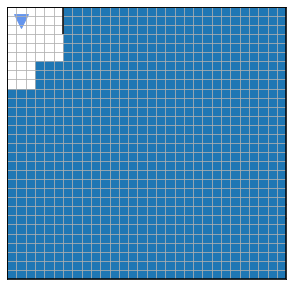

In [49]:
dungeon = Dungeon({3:5}, plot_size=10)

Input your direction (wasd) or type 'encounter': s


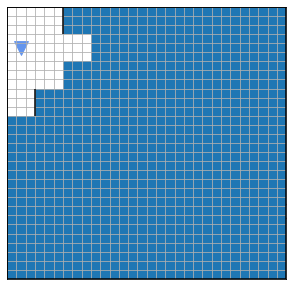

Input your direction (wasd) or type 'encounter': d


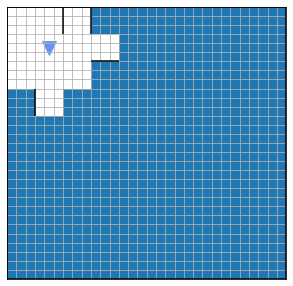

Input your direction (wasd) or type 'encounter': d


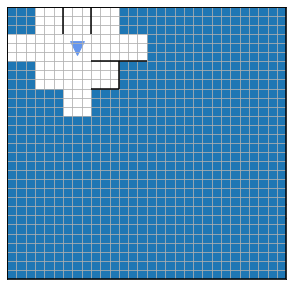

Input your direction (wasd) or type 'encounter': d


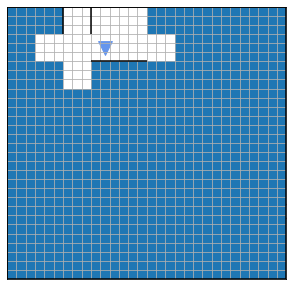

Input your direction (wasd) or type 'encounter': d


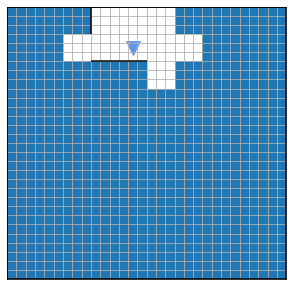

Input your direction (wasd) or type 'encounter': d


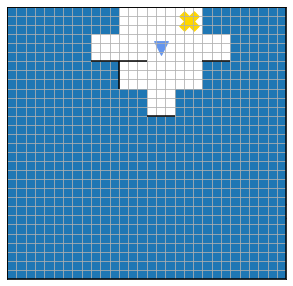

Input your direction (wasd) or type 'encounter': encounter


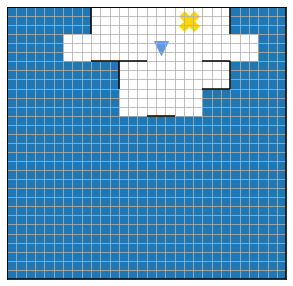

Medium :
{'merrenoloth': 1, 'boggle': 1}
Does this look right? (y/n)y
Input your direction (wasd) or type 'encounter': w


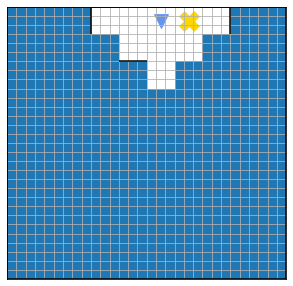

Input your direction (wasd) or type 'encounter': d


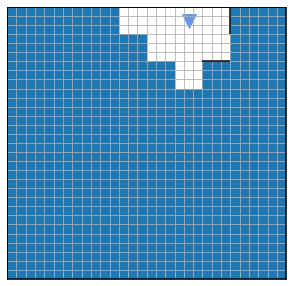

Input your direction (wasd) or type 'encounter': s


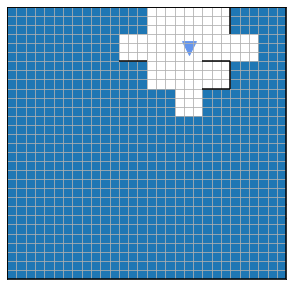

Input your direction (wasd) or type 'encounter': encounter


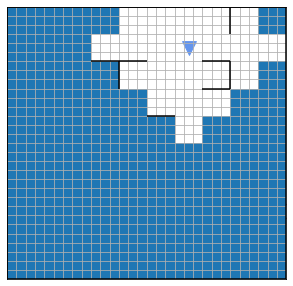

Hard :
{'troglodyte': 8, 'ice-toad': 1}


KeyboardInterrupt: 

In [50]:
dungeon.play()